Population Data
Link: https://hub.worldpop.org/geodata/summary?id=6407
Reference: WorldPop (www.worldpop.org - School of Geography and Environmental Science, University of Southampton; Department of Geography and Geosciences, University of Louisville; Departement de Geographie, Universite de Namur) and Center for International Earth Science Information Network (CIESIN), Columbia University (2018). Global High Resolution Population Denominators Project - Funded by The Bill and Melinda Gates Foundation (OPP1134076). https://dx.doi.org/10.5258/SOTON/WP00645

In [2]:
import geopandas as gpd
import rasterio
from rasterstats import zonal_stats
import pandas as pd

In [3]:
# Paths to raster and shapefile
raster_path = "/home/manish/Desktop/Personal/Application/AON/Population_world_pop/mys_ppp_2020.tif"
shapefile_path = "/home/manish/Desktop/Personal/Application/AON/mys_adm_unhcr_20210211_shp/WGS/mys_admbndp_admALL_unhcr_itos_20210211.shp"

# Read the shapefile
gdf = gpd.read_file(shapefile_path)

# Open raster dataset
with rasterio.open(raster_path) as src:
    # Extract raster values within each polygon
    stats = zonal_stats(gdf, src.read(1), affine=src.transform, nodata=src.nodata, stats=["sum"])

# Add zonal sum as a new column to the GeoDataFrame
gdf["zonal_sum"] = [stat["sum"] for stat in stats]

# Print the GeoDataFrame with zonal sums
print(gdf)


              ADM1_EN ADM1_PCODE   ADM0_EN ADM0_PCODE        date     validOn  \
0               Johor       MY01  Malaysia         MY  2020-12-02  2021-02-11   
1               Kedah       MY02  Malaysia         MY  2020-12-02  2021-02-11   
2            Kelantan       MY03  Malaysia         MY  2020-12-02  2021-02-11   
3              Melaka       MY06  Malaysia         MY  2020-12-02  2021-02-11   
4     Negeri Sembilan       MY07  Malaysia         MY  2020-12-02  2021-02-11   
5              Pahang       MY08  Malaysia         MY  2020-12-02  2021-02-11   
6               Perak       MY09  Malaysia         MY  2020-12-02  2021-02-11   
7              Perlis       MY10  Malaysia         MY  2020-12-02  2021-02-11   
8        Pulau Pinang       MY11  Malaysia         MY  2020-12-02  2021-02-11   
9               Sabah       MY12  Malaysia         MY  2020-12-02  2021-02-11   
10            Sarawak       MY13  Malaysia         MY  2020-12-02  2021-02-11   
11           Selangor       

Validation for the population

In [61]:
df = pd.read_csv("/home/manish/Desktop/Personal/Application/AON/population_state.csv")

In [62]:
if 'date' in df.columns: df['date'] = pd.to_datetime(df['date'])
df = df[df.age == "overall_age"]
df = df[df.sex == "overall_sex"]
df =df[df.ethnicity == "overall_ethnicity"]
df= df[df.date == "2023-01-01"]
df["population_worldpop"] = gdf["zonal_sum"].values
df["population"] = df["population"]*1000
df.to_csv("Statewise_population.csv")

In [6]:
gdf["population_worldpop"] = df["population"].values

In [ ]:
gdf

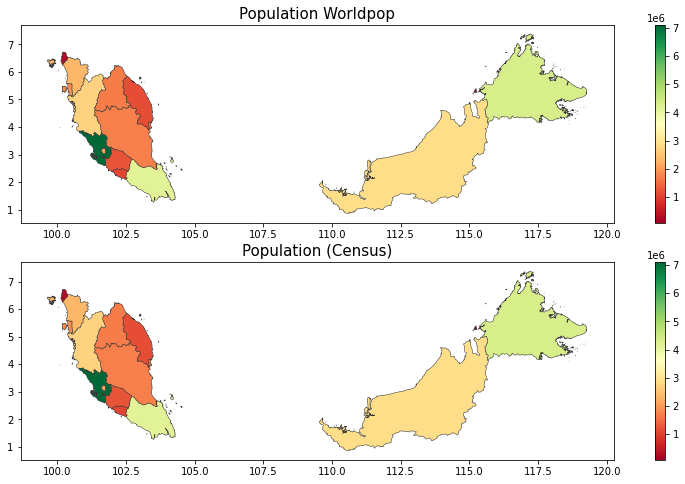

In [59]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, figsize=(15, 8))
ax[0].set_title('Population Worldpop',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
gdf.plot(column='zonal_sum', cmap='RdYlGn', linewidth=0.5, ax=ax[0], edgecolor='0.2',legend=True)

ax[1].set_title('Population (Census)',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
gdf.plot(column='zonal_sum', cmap='RdYlGn', linewidth=0.5, ax=ax[1], edgecolor='0.2',legend=True)
plt.savefig("Population.png",dpi=500)

## 1b) Create a script to profile population in each district of Selangor state. Classify the population to bands of your choice. The goal is to be able to assign relative importance to each district within the state

<Axes: >

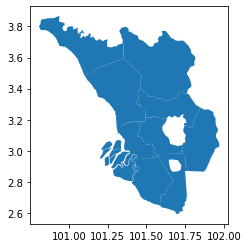

In [64]:
Districts = gpd.read_file("/home/manish/Desktop/Personal/Application/AON/mys_adm_unhcr_20210211_shp/mys_admbnda_adm2_unhcr_20210211.shp")
Districts
selangor = Districts[Districts.ADM1_EN == "Selangor"]
selangor.plot()

In [65]:
#Extract the population
with rasterio.open(raster_path) as src:
    # Extract raster values within each polygon
    stats = zonal_stats(selangor, src.read(1), affine=src.transform, nodata=src.nodata, stats=["sum"])

# Extract zonal sum values
zonal_sum_values = [stat["sum"] for stat in stats]

# Add zonal sum as a new column to the GeoDataFrame
selangor.loc[:, "zonal_sum"] = zonal_sum_values

/home/manish/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [75]:
selangor_df = pd.DataFrame()
selangor_df["District"] = selangor["ADM2_EN"].values
selangor_df["Population"] = selangor["zonal_sum"].values
selangor_df.to_csv("selangor_district_population.csv")

## Classify population into bands 
#### Classification: low (< 100,000), medium (100,000 - 500,000), high (> 500,000)

In [76]:
bins = [0, 100000, 500000, float('inf')]
labels = ['Low', 'Medium', 'High']
selangor_df['Bands'] = pd.cut(selangor_df['Population'], bins=bins, labels=labels)
selangor_df


,District,Population,Bands
0,Gombak,9.594783e+05,High
1,Ulu Langat,1.468511e+06,High
2,Ulu Selangor,2.545642e+05,Medium
3,Klang,1.094252e+06,High
4,Kuala Langat,2.308367e+05,Medium
5,Kuala Selangor,2.700522e+05,Medium
6,Petaling,2.369712e+06,High
7,Sabak Bernam,9.462838e+04,Low
8,Sepang,3.604006e+05,Medium


/home/manish/anaconda3/lib/python3.9/site-packages/geopandas/geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


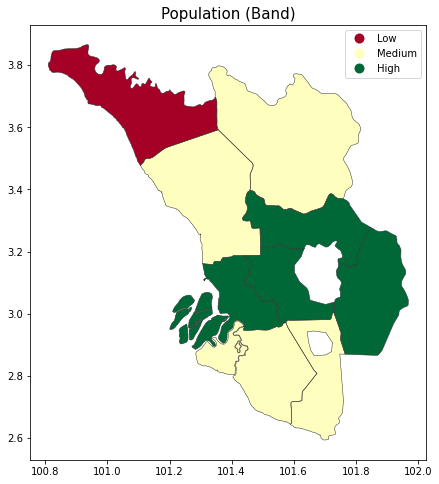

In [82]:
selangor["Population_Band"] = selangor_df.Bands.values
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.set_title('Population (Band)',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
selangor.plot(column='Population_Band', cmap='RdYlGn', linewidth=0.5, ax=ax,legend=True,)
selangor.plot(facecolor='none',linewidth=0.5, ax=ax,edgecolor='0.2')
plt.savefig("1b.png",dpi=500)

In [84]:
Districts = gpd.read_file("/home/manish/Desktop/Personal/Application/AON/mys_adm_unhcr_20210211_shp/mys_admbnda_adm2_unhcr_20210211.shp")
#Extract the population
with rasterio.open(raster_path) as src:
    # Extract raster values within each polygon
    stats = zonal_stats(Districts, src.read(1), affine=src.transform, nodata=src.nodata, stats=["sum"])

# Extract zonal sum values
zonal_sum_values = [stat["sum"] for stat in stats]

# Add zonal sum as a new column to the GeoDataFrame
Districts.loc[:, "zonal_sum"] = zonal_sum_values

dis_df = pd.DataFrame()
dis_df["District"] = Districts["ADM2_EN"].values
dis_df["Population"] = Districts["zonal_sum"].values
dis_df['Bands'] = pd.cut(dis_df['Population'], bins=bins, labels=labels)
dis_df.to_csv("All_district_population.csv")

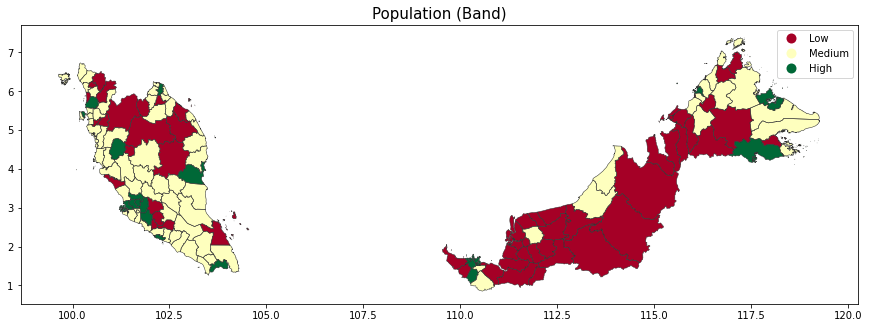

In [87]:
Districts["Population_Band"] = dis_df.Bands.values
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.set_title('Population (Band)',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
Districts.plot(column='Population_Band', cmap='RdYlGn', linewidth=0.5, ax=ax,legend=True,)
Districts.plot(facecolor='none',linewidth=0.5, ax=ax,edgecolor='0.2')
plt.savefig("1b_all_D.png",dpi=500)

In [99]:
dis_df["State"] = Districts.ADM1_EN.values

In [101]:
grouped_df = dis_df.pivot_table(index='State', columns='Bands', values='Population', aggfunc='sum', fill_value=0,observed=True)
grouped_df.to_csv("state_wise_classification.csv")
grouped_df

Bands,Low,Medium,High
State,,,
Johor,7.424304e+04,2.147990e+06,1.895229e+06
Kedah,3.402894e+05,1.398711e+06,5.742009e+05
Kelantan,2.405663e+05,8.866507e+05,5.508995e+05
Melaka,0.000000e+00,4.061747e+05,6.183068e+05
Negeri Sembilan,2.408971e+05,2.118884e+05,7.499722e+05
Pahang,1.449596e+05,9.757937e+05,5.674826e+05
Perak,1.404019e+05,1.541304e+06,1.021015e+06
Perlis,0.000000e+00,2.564199e+05,0.000000e+00
Pulau Pinang,0.000000e+00,1.247351e+06,6.279924e+05


## 1 (c): Create a script to generate a 100m x 100m uniform vector grid within Klang district of Selangor state and calculate total population in each grid.

<Axes: >

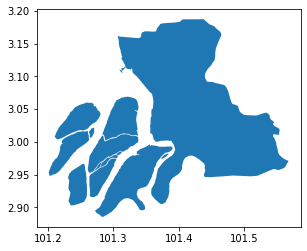

In [23]:
klang = selangor[selangor["ADM2_EN"]=="Klang"]
klang.plot()
#klang = klang.to_crs(epsg=32647, inplace=False)  #UTM zone 47

In [60]:
import geopandas as gpd
import numpy as np
import rasterio
from rasterio.features import geometry_mask
from rasterstats import zonal_stats
from shapely.geometry import box


0.001 = 111 m

In [40]:
# Get bounding box of Klang district
xmin, ymin, xmax, ymax = klang.total_bounds

# Generate grid covering the extent of Klang district with 100m x 100m cell size
grid_cells = []
for x in np.arange(xmin, xmax, 0.001):
    for y in np.arange(ymin, ymax, 0.001):
        grid_cells.append(box(x, y, min(x + 0.001, xmax), min(y + 0.001, ymax)))

# Create GeoDataFrame from grid cells
grid_gdf = gpd.GeoDataFrame(geometry=grid_cells, crs=klang.crs)
# Clip grid to Klang district boundary
grid_gdf = gpd.clip(grid_gdf, klang)

In [46]:
# Open population raster
with rasterio.open(raster_path) as src:
    # Mask population raster with Klang district boundary
    mask = geometry_mask(klang.geometry, transform=src.transform, out_shape=src.shape, invert=True)
    population_data = src.read(1, masked=True)

    # Calculate zonal statistics for population within each grid cell
    stats = zonal_stats(grid_gdf, population_data, affine=src.transform, nodata=src.nodata, stats=["sum"])

# Extract total population from zonal stats
total_population = [stat["sum"] if stat["sum"] is not None else 0 for stat in stats]

# Add total population as a new column to the grid GeoDataFrame
grid_gdf["total_population"] = total_population

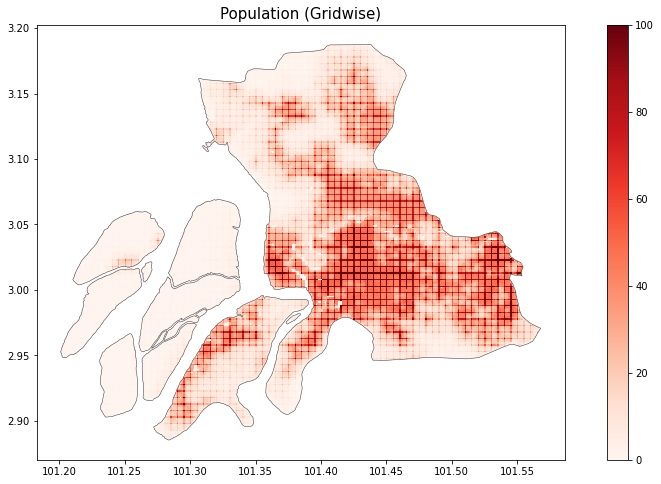

In [57]:
fig, ax = plt.subplots(1, figsize=(15, 8))
ax.set_title('Population (Gridwise)',
             fontdict={'fontsize': '15', 'fontweight' : '3'})
grid_gdf.plot(column='total_population', cmap='Reds', linewidth=0.5, ax=ax,legend=True,vmin=0, vmax=100)
klang.plot(facecolor='none',linewidth=0.5, ax=ax,edgecolor='0.2')
plt.savefig("Klang_grid100m.png",dpi=500)